In [1]:
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import scipy.integrate
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix, triu, spdiags
from scipy.sparse.linalg import spsolve, splu
import scipy.sparse
import scipy.optimize
from numpy.linalg import inv

import time

### Number 1

In [2]:
#initialize 
Time = 2
L = 10
n = 128 
x2 = np.linspace(-L, L, n+1)
x = x2[0:n]
dx = x[1]-x[0]

#time
t = np.linspace(0, Time, 501)
dt = t[1] - t[0]
time_steps = int(Time/dt)

CFL = (2*dt)/(dx**2) 
CFL

0.32768

### Number 2 (A1)

In [3]:
#von-Neumann analysis 

G = lambda l,z: (1/6)*(6-(15*l)+(16*l*np.cos(z))-(l*np.cos(2*z)))

# zvals = np.linspace(-np.pi,np.pi,128)
# lvals = np.linspace(0,3,128)
# [Z, L] = np.meshgrid(zvals,lvals)

# fig,ax = plt.subplots(figsize=(10,10),subplot_kw = {"projection":"3d"})
# ax.plot_surface(Z,L,G(L,Z), cmap = "magma")

A1 = np.abs(G(CFL,1))

In [4]:
A1

0.6756505247982867

### Number 3 (A2)

In [5]:
G_one = lambda z: np.abs(G(CFL,z))
x_optimize = scipy.optimize.fminbound(lambda z:-G_one(z), -np.pi,np.pi) # This gives the *maximizer*
A2 = G_one(x_optimize)

In [6]:
A2

1.0

### Number 4 (A3)

In [7]:
def matrix_FE(n):
    e1 = np.ones(n)
    A = scipy.sparse.spdiags([-e1, -e1,16*e1,30*e1,16*e1,-e1, -e1], [-n+2,-2,-1,0,1,2,n-2],n,n, format = 'csc')
    A[0,n-1] = 16
    A[n-1,0] = 16
    
    A = A/12
    
    return A 

In [8]:
A3 = matrix_FE(128).todense()

/Users/annahuang/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### Number 6 (A5)

In [9]:
#Forward Euler 
def FE(A, n):
    L = 10
    x2 = np.linspace(-L, L, n+1)
    x = x2[0:n]
    
    usol_fe = np.zeros((len(x), len(t)))
    u0 = (10*np.cos((2*np.pi*x)/L) + 30*np.cos((8*np.pi*x)/L)).T
    usol_fe[:,0] = u0

    u1 = u0
    for j in range(time_steps):
        u2 = u1 + 0.5*CFL*A@u1
        u1 = u2
        usol_fe[:,j+1] = u2
    
    return usol_fe

In [10]:
# FE(matrix_FE(128), 128)

In [11]:
A5 = FE(matrix_FE(128), 128)[:,-1].reshape(128,1)

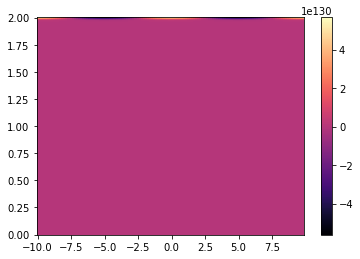

In [12]:
# plotting 
fig, ax = plt.subplots(1,1)
T, X = np.meshgrid(t,x)
cp = ax.pcolor(x, t, FE(matrix_FE(128), 128).T, cmap='magma', shading='auto')
fig.colorbar(cp)
plt.show()

# A lot of instability in this solution 

### Number 7 (A6)

In [13]:
G1 = lambda l,z: (1-l+(l*np.cos(z)))/(1+l-(l*np.cos(z)))

G_one1 = lambda z: np.abs(G1(CFL,z))
x_optimize1 = scipy.optimize.fminbound(lambda z:-G_one1(z), -np.pi,np.pi) # This gives the *maximizer*
A6 = G_one1(x_optimize1)

In [14]:
A6

1.0

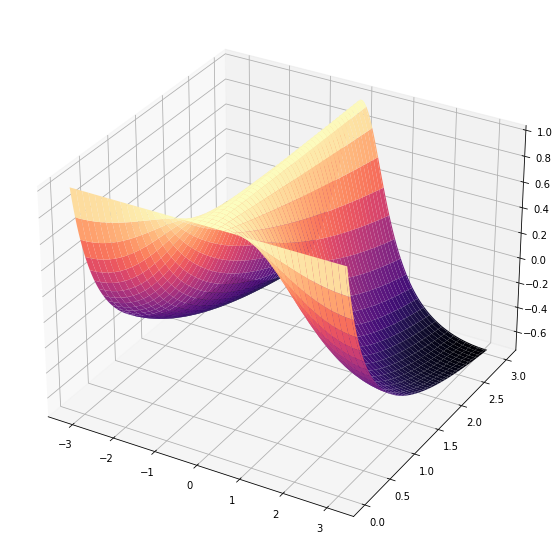

In [15]:
zvals = np.linspace(-np.pi,np.pi,128)
lvals = np.linspace(0,3,128)
[Z, L] = np.meshgrid(zvals,lvals)

fig,ax = plt.subplots(figsize=(10,10),subplot_kw = {"projection":"3d"})
ax.plot_surface(Z,L,G1(L,Z), cmap = "magma")

### Number 8 (A7 & A8)

In [16]:
def matrix_PLU(n):
    e1 = np.ones(n)
    
    M = scipy.sparse.spdiags([e1,-2*e1,e1], [-1,0,1],n,n, format = 'csc')
    
    M[0,n-1] = 1
    M[n-1,0] = 1
    
    B = (scipy.sparse.eye(n) - ((CFL/2)*M))
    C = (scipy.sparse.eye(n) + ((CFL/2)*M))
    
    return B, C

In [17]:
B = matrix_PLU(128)[0]
C = matrix_PLU(128)[1]
# A = scipy.sparse.linalg.inv(B*C)

In [18]:
A7 = B.todense()
A8 = C.todense()

### Number 9 (A9)

In [19]:
def PLU(B,C, n):
    L = 10
    x2 = np.linspace(-L, L, n+1)
    x = x2[0:n]

    PLU = scipy.sparse.linalg.splu(C)/B
    
    usol_plu = np.zeros((len(x),len(t))) #placeholder for solution - more effcient
    u0 = (10*np.cos((2*np.pi*x)/L) + 30*np.cos((8*np.pi*x)/L)).T
    usol_plu[:,0] = u0

    start = time.time()
    for j in range(time_steps):
        u1 = PLU.solve(u0)
        u0 = u1 
        usol_plu[:,j+1] = u1

    end = time.time()
    # print(end-start)
    
    return usol_plu

In [20]:
A9 = PLU(B,C, 128)[:,-1].reshape(128,1)

/Users/annahuang/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


TypeError: unsupported operand type(s) for /: 'SuperLU' and 'csr_matrix'

In [ ]:
#plotting x and t 
fig,ax = plt.subplots(1,1)
T,X = np.meshgrid(t,x)
cp=ax.pcolor(x,t,PLU(A, 128).T,cmap="magma",shading = 'auto')
fig.colorbar(cp)
plt.show()

### Number 10 (A10)

In [23]:
def BIC(A, n):
    L = 10
    x2 = np.linspace(-L, L, n+1)
    x = x2[0:n]
    dx = x[1]-x[0]
    
    A_BIC = scipy.sparse.linalg.inv(B)*C
    
    usol_bic =np.zeros((len(x),len(t))) #placeholder for solution - more effcient
    u0 = (10*np.cos((2*np.pi*x)/L) + 30*np.cos((8*np.pi*x)/L)).T
    usol_bic[:,0] = u0

    start = time.time()

    for j in range(time_steps):
        u1,info= scipy.sparse.linalg.bicgstab(A_BIC,u0,x0 = u0)
        u0=u1
        usol_bic[:,j+1] = u1

    end = time.time()
    
    return usol_bic

In [24]:
A10 = BIC(A, 128)[:,-1].reshape(128,1)

### Number 11 (A11 & A12)

In [25]:
exact_128 = np.genfromtxt("exact_128.csv", delimiter=',')

In [26]:
A11 = np.linalg.norm(exact_128-A5)

In [27]:
A11

5.1091497362223745e+132

In [28]:
A12 = np.linalg.norm(exact_128-A9)

In [29]:
A12

2192.899284813238

### Number 12 (A13 & A14)

In [30]:
exact_256 = np.genfromtxt("exact_256.csv", delimiter=',')

In [31]:
A13 = np.linalg.norm(exact_256-FE(matrix_FE(256), 256)[:,-1].reshape(256,1))

In [32]:
A13

1.6413449356839313e+133

In [33]:
B256 = matrix_PLU(256)[0]
C256 = matrix_PLU(256)[1]
A256 = scipy.sparse.linalg.inv(B256)*C256

In [34]:
A14 = np.linalg.norm(exact_256-PLU(A256, 256)[:,-1].reshape(256,1))

In [35]:
A14

nan